In [13]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm
from collections import defaultdict

In [21]:
import importlib
import functions
importlib.reload(functions)
functions.set_user('Helen')
data = functions.call_data_clean(p_threshold=1.3)

ATAC = data['ATAC_top'] # only high variance peaks
ATAC_scores = data['norm_scores']
ATAC_scores_T = ATAC_scores.T
RNA = data['RNA_seq']
RNA_T = data['RNA_seq_T']
Exons = data['exons']

#lineage abgd subset
atac_abgd_cols= data['list_ATAC_Tc_ab_gd']
atac_abgd = data['ATAC_seq'].loc[:, atac_abgd_cols]
ab_gd= data['ab_gd_tc']
ab= data['ab_tc']
gd= data['gd_tc']
rna_abgd = data['RNA_seq'].loc[:, ab_gd]






Can one use regression to associate CREs with gene expression?

we will try to answer this question by using linear (lasso) regression to predict gene expression based on accessibility of linked promoter and enhancers (CREs) by linking ATAC peaks to genes via their proximity to the TSS 

here we are plotting an R^2 barplot. Here a high R^2(exlained variance) shows a strong lnk betwenn CREs and gene expression to shows whic CREs play a larger role here. and show us if accessible CREs containe nough information in order to predict gene expression

also we will show a coefficient plot which illustrates whether individual CREs act repressing(negative value) or activating (positive value)

lastly a histogramm showing the distribuiton of r^2 throughout different genes will show how much of the variance of gene expression can be explained for each gene with this approach. 

In [22]:
#lasso regression (r2 barplot, coef plot top gene and r2 distribution histogram)

def get_tss(row):
    # Use the correct column names from Exons
    if row["Strand"] == "+":
        return row["Transcription Start"]
    else:
        return row["Transcription End"]  # or another column if appropriate

Exons["TSS"] = Exons.apply(get_tss, axis=1)

linked_data = []
for _, gene_row in Exons.iterrows():
    gene_name = gene_row["Genname"]
    chrom = gene_row["Chromosom"]
    tss = gene_row["TSS"]

    
    nearby_peaks = ATAC[
        (ATAC["chrom"] == chrom) &
        (np.abs(ATAC["Summit"] - tss) <= 100_000)
    ]

    for _, peak_row in nearby_peaks.iterrows():
        # Ensure peak_row.name is always a string (peak ID)
        peak_id = str(peak_row.name)
        linked_data.append({
            "GeneName": gene_name,
            "PeakID": peak_id,
            "DistanceToTSS": np.abs(peak_row["Summit"] - tss)
        })

link_df = pd.DataFrame(linked_data)


In [23]:
# Pre-filter only genes with links
linked_genes = link_df["GeneName"].unique()
genes_to_run = RNA.index.intersection(linked_genes)

# Shared samples between both dataframes
shared_samples = RNA.columns.intersection(ATAC.columns)

# Pretranspose ATAC for faster access later
ATAC_T = ATAC[shared_samples].T
RNA_filtered = RNA.loc[genes_to_run, shared_samples]

# Convert link_df to dictionary {gene: [peak_ids]}
gene_to_peaks = link_df.groupby("GeneName")["PeakID"].apply(list).to_dict()


In [24]:
#lasso regression run
def run_lasso_for_gene(gene):
    try:
        peaks = gene_to_peaks.get(gene, [])
        if len(peaks) < 2:
            return None, None

        # Filter ATAC by peaks
        valid_peaks = [p for p in peaks if p in ATAC_T.columns]
        if len(valid_peaks) < 2:
            return None, None

        X = ATAC_T[valid_peaks].fillna(0).values
        y = RNA_filtered.loc[gene].values

        if np.linalg.matrix_rank(X) < 2:
            return None, None

        model = LassoCV(cv=3, n_alphas=20, n_jobs=-1).fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)

        return {
            "Gene": gene,
            "R2": r2,
            "Num_CRs": X.shape[1]
        }, pd.Series(model.coef_, index=valid_peaks)

    except Exception as e:
        print(f"Error with {gene}: {e}")
        return None, None

# Run in parallel with tqdm support
from joblib import parallel_backend

with parallel_backend("loky"):
    parallel_results = list(tqdm(
        Parallel(n_jobs=-1)(delayed(run_lasso_for_gene)(gene) for gene in genes_to_run),
        total=len(genes_to_run),
        desc="Running Lasso"
    ))

# Collect results
results = []
coefs = {}

for res, coef in parallel_results:
    if res is not None:
        results.append(res)
        coefs[res['Gene']] = coef

# To DataFrame
results_df = pd.DataFrame(results).sort_values("R2", ascending=False)


Running Lasso: 100%|██████████| 6202/6202 [00:00<00:00, 1701869.38it/s]


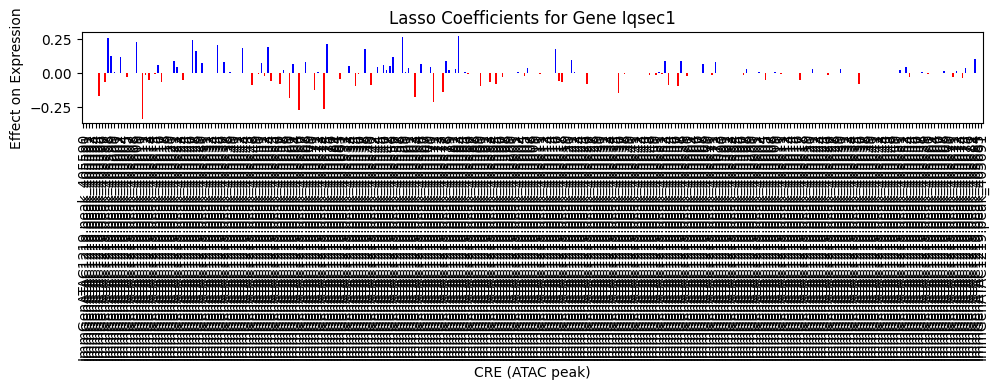

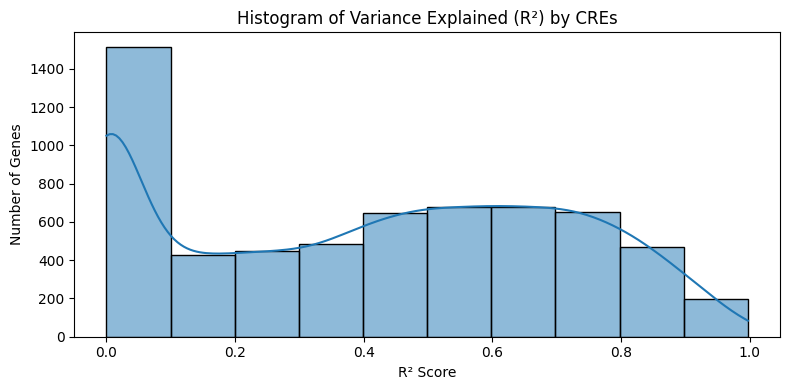

C:\Users\helen\AppData\Local\Temp\ipykernel_19428\1446759938.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Gene", y="R2", palette="viridis")


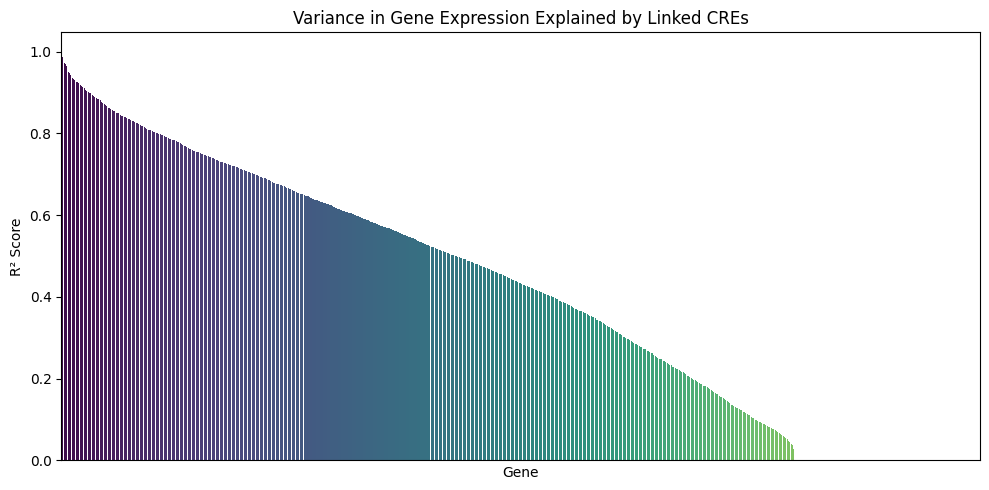

In [ ]:
# lasso rg plot top gene coefficients
top_gene = results_df.iloc[0]["Gene"]
top_coef_series = coefs[top_gene]

plt.figure(figsize=(10, 4))
top_coef_series.plot(kind='bar', color=['red' if v < 0 else 'blue' for v in top_coef_series])
plt.title(f"Lasso Coefficients for Gene {top_gene}")
plt.ylabel("Effect on Expression")
plt.xlabel("CRE (ATAC peak)")
plt.tight_layout()
plt.show()

# Histogram of R² scores
plt.figure(figsize=(8, 4))
sns.histplot(results_df['R2'], bins=10, kde=True)
plt.title("Histogram of Variance Explained (R²) by CREs")
plt.xlabel("R² Score")
plt.ylabel("Number of Genes")
plt.tight_layout()
plt.show()

# bar plot of R² scores (for each gene)
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Gene", y="R2", palette="viridis")
plt.title("Variance in Gene Expression Explained by Linked CREs")
plt.ylabel("R² Score")
plt.xticks([],[])
plt.tight_layout()
plt.show()


our histogram is conclusive with what is normally expected from real data. A high R^2 value indicates strong CRE regulation. It is shown, that many genes are higly independent from CREs (low R^2 value)e.g houskeeping, stable genes, most with R^2 between 0.2-0.9 are partially regulated by nearby CREs, and lastly there is a long tail until R^2=1 which show that some genes are dominantly regulated by local CREs (lineage specific enhancer control) the top 5 being  qsec1,	Nap1l1,	Cdk4,	Tnfrsf1b and Rgs3

# How do the coefficients differ when this analysis is performed on only abT and gdT cells?

This asks:

How does the importance of each CRE (in predicting gene expression) change when we restrict analysis to only our specific lineage instaead of to using all samples?

c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.435e-05, tolerance: 8.093e-05
  model = cd_fast.enet_coordinate_descent(
c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e-03, tolerance: 8.093e-05
  model = cd_fast.enet_coordinate_descent(
c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the nu

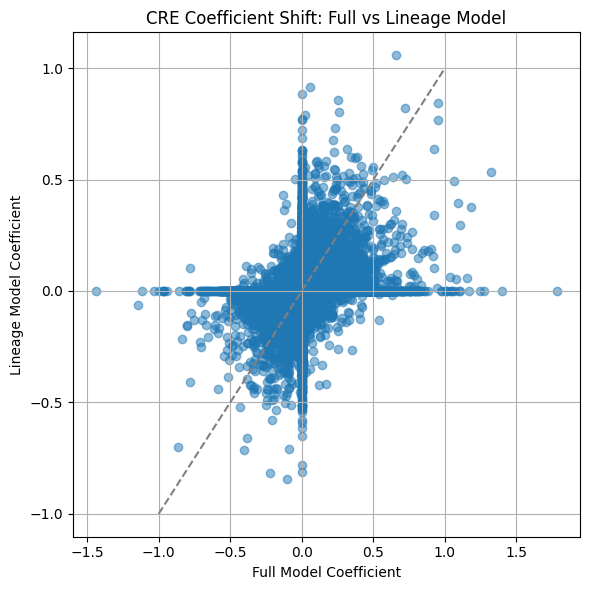

In [26]:
#coefficient plot for subset ab and gd t cells

abgd_results = []

for gene, group in link_df.groupby("GeneName"):
    if gene not in rna_abgd.index:
        continue
    y = rna_abgd.loc[gene].values

    peak_ids = group["PeakID"].values
    # Only keep peak_ids that are in atac_abgd

    valid_peak_ids = [pid for pid in peak_ids if pid in atac_abgd.index ]
    if len(valid_peak_ids) < 2:
        continue

    x = atac_abgd.loc[valid_peak_ids].T.values  # shape: (samples, peaks)

    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)

    model_lineage = LassoCV(cv=5).fit(x_scaled, y)

    abgd_results.append({
        "GeneName": gene,
        "PeakIDs": valid_peak_ids,
        "LineageCoefs": model_lineage.coef_
    })

full_model_results = []
for gene, coef_series in coefs.items():
    full_model_results.append({
        "GeneName": gene,
        "PeakIDs": list(coef_series.index),
        "FullCoefs": coef_series.values
    })

comparison = []

for lineage in abgd_results:
    gene = lineage["GeneName"]
    peak_ids = lineage["PeakIDs"]

    full = next(
        (f for f in full_model_results if f["GeneName"] == gene and list(f["PeakIDs"]) == list(peak_ids)), 
        None
    )
    
    if full is None:
        continue

    diff = full["FullCoefs"] - lineage["LineageCoefs"]

    for i, peak in enumerate(peak_ids):
        comparison.append({
            "GeneName": gene,
            "PeakID": peak,
            "FullCoef": full["FullCoefs"][i],
            "LineageCoef": lineage["LineageCoefs"][i],
            "Difference": diff[i]
        })


comp_df = pd.DataFrame(comparison)

plt.figure(figsize=(6, 6))
plt.scatter(comp_df["FullCoef"], comp_df["LineageCoef"], alpha=0.5)
plt.plot([-1, 1], [-1, 1], linestyle="--", color="gray")  # identity line
plt.xlabel("Full Model Coefficient")
plt.ylabel("Lineage Model Coefficient")
plt.title("CRE Coefficient Shift: Full vs Lineage Model")
plt.grid(True)
plt.tight_layout()
plt.show()

#too large to run
pivot = comp_df.pivot(index="GeneName", columns="PeakID", values="Difference")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot.fillna(0), cmap="coolwarm", center=0)
plt.title("Coefficient Differences (Full - Lineage)")
plt.xlabel("CRE (Peak)")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()



Interpretation
Points far from diagonal in the scatterplot = CREs whose importance changes between full and lineage models.

Positive differences: CRE is stronger in full model than in lineage (possibly due to other lineages).

Negative differences: CRE is stronger in lineage (lineage-specific regulation).

Heatmap: identifies which CREs are lineage-specific regulators.

now we will analize which CREs are active in ab_tc & gd_tc cell lineages, by ranking different CREs absolute regression coefficients in a CRE-bipartile network graph a CRE importance heatmap and a barplot of top CREs for our specific lineage whereas CREs at the top of the barplot are likely to drive expression of lineage-specific genes. 

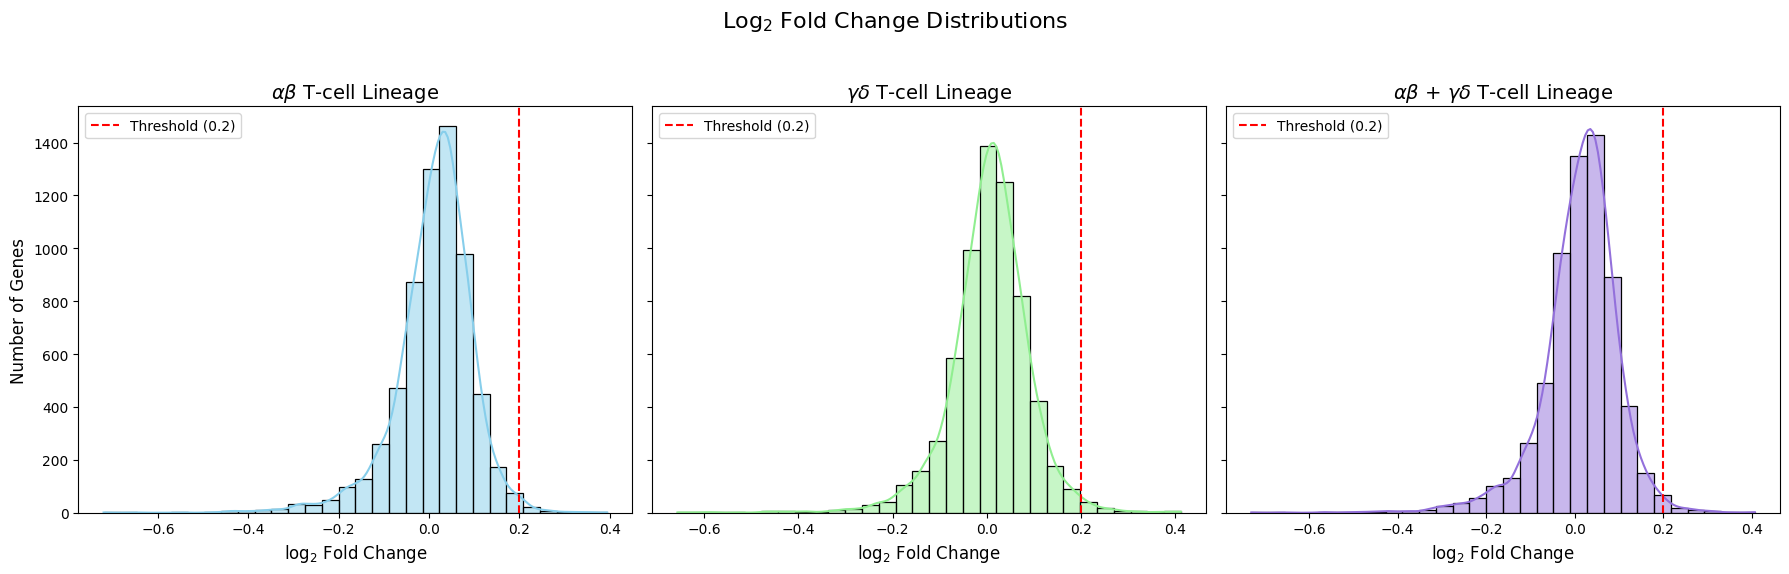

C:\Users\helen\AppData\Local\Temp\ipykernel_19428\3358367568.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_abgd.head(top_cres_to_plot), x="Gene", y="R2", palette="viridis")


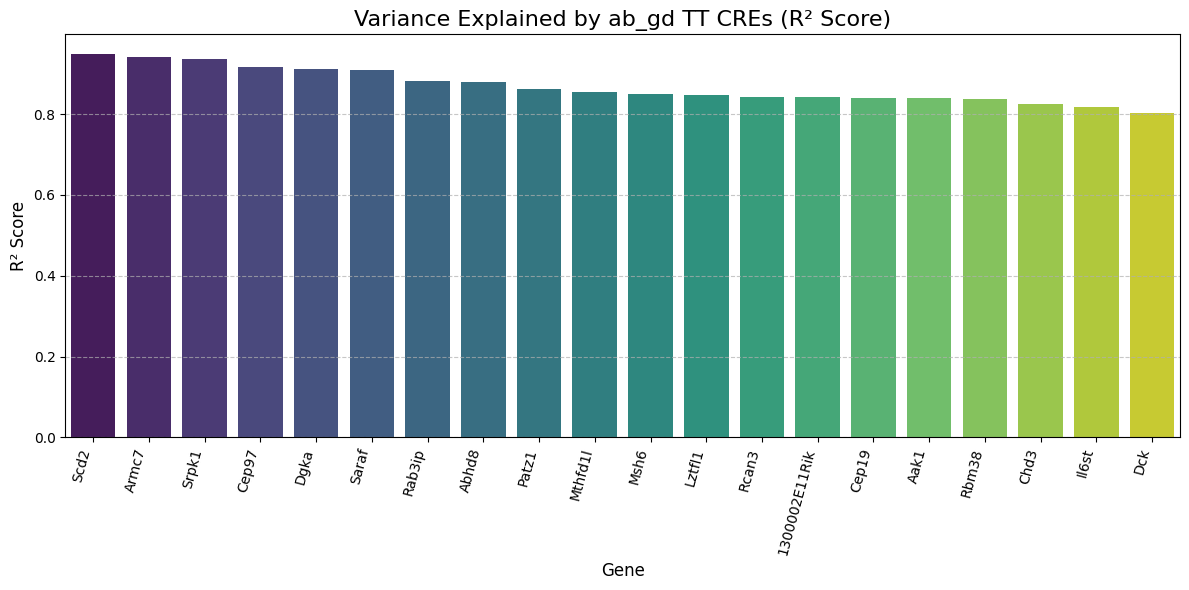

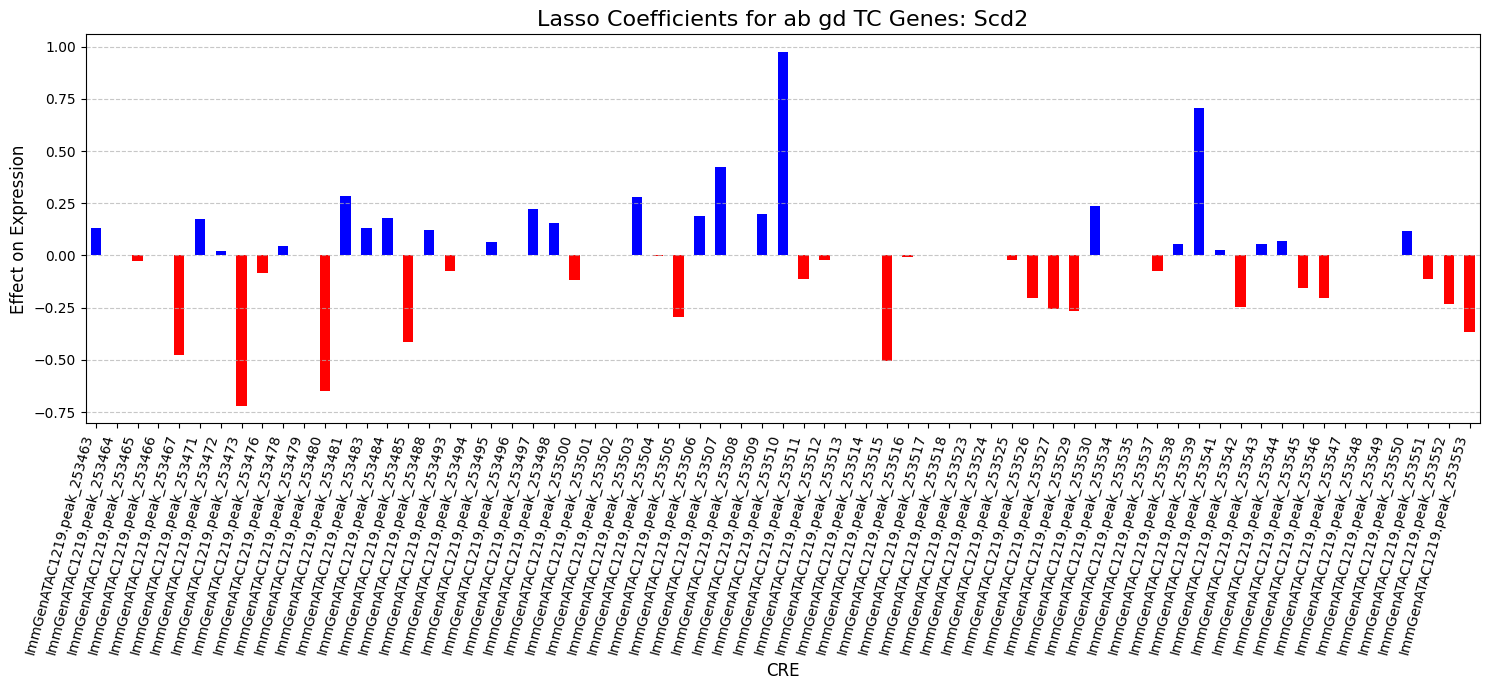

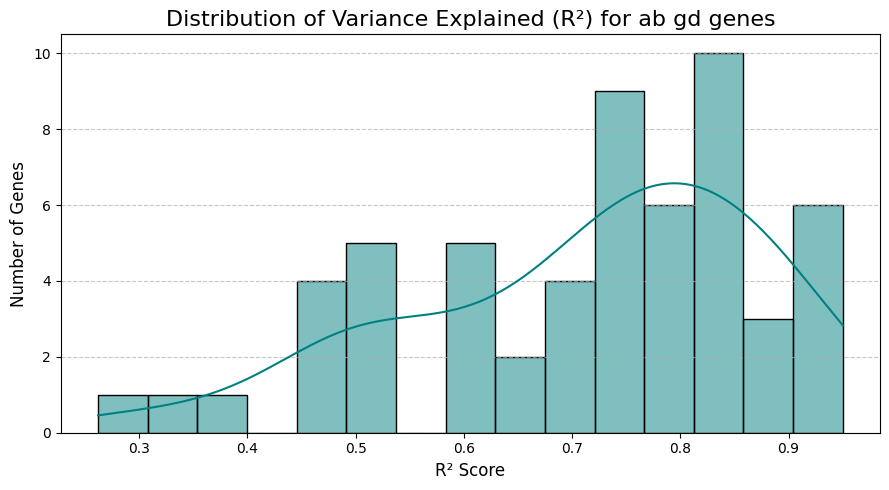

C:\Users\helen\AppData\Local\Temp\ipykernel_19428\3358367568.py:169: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


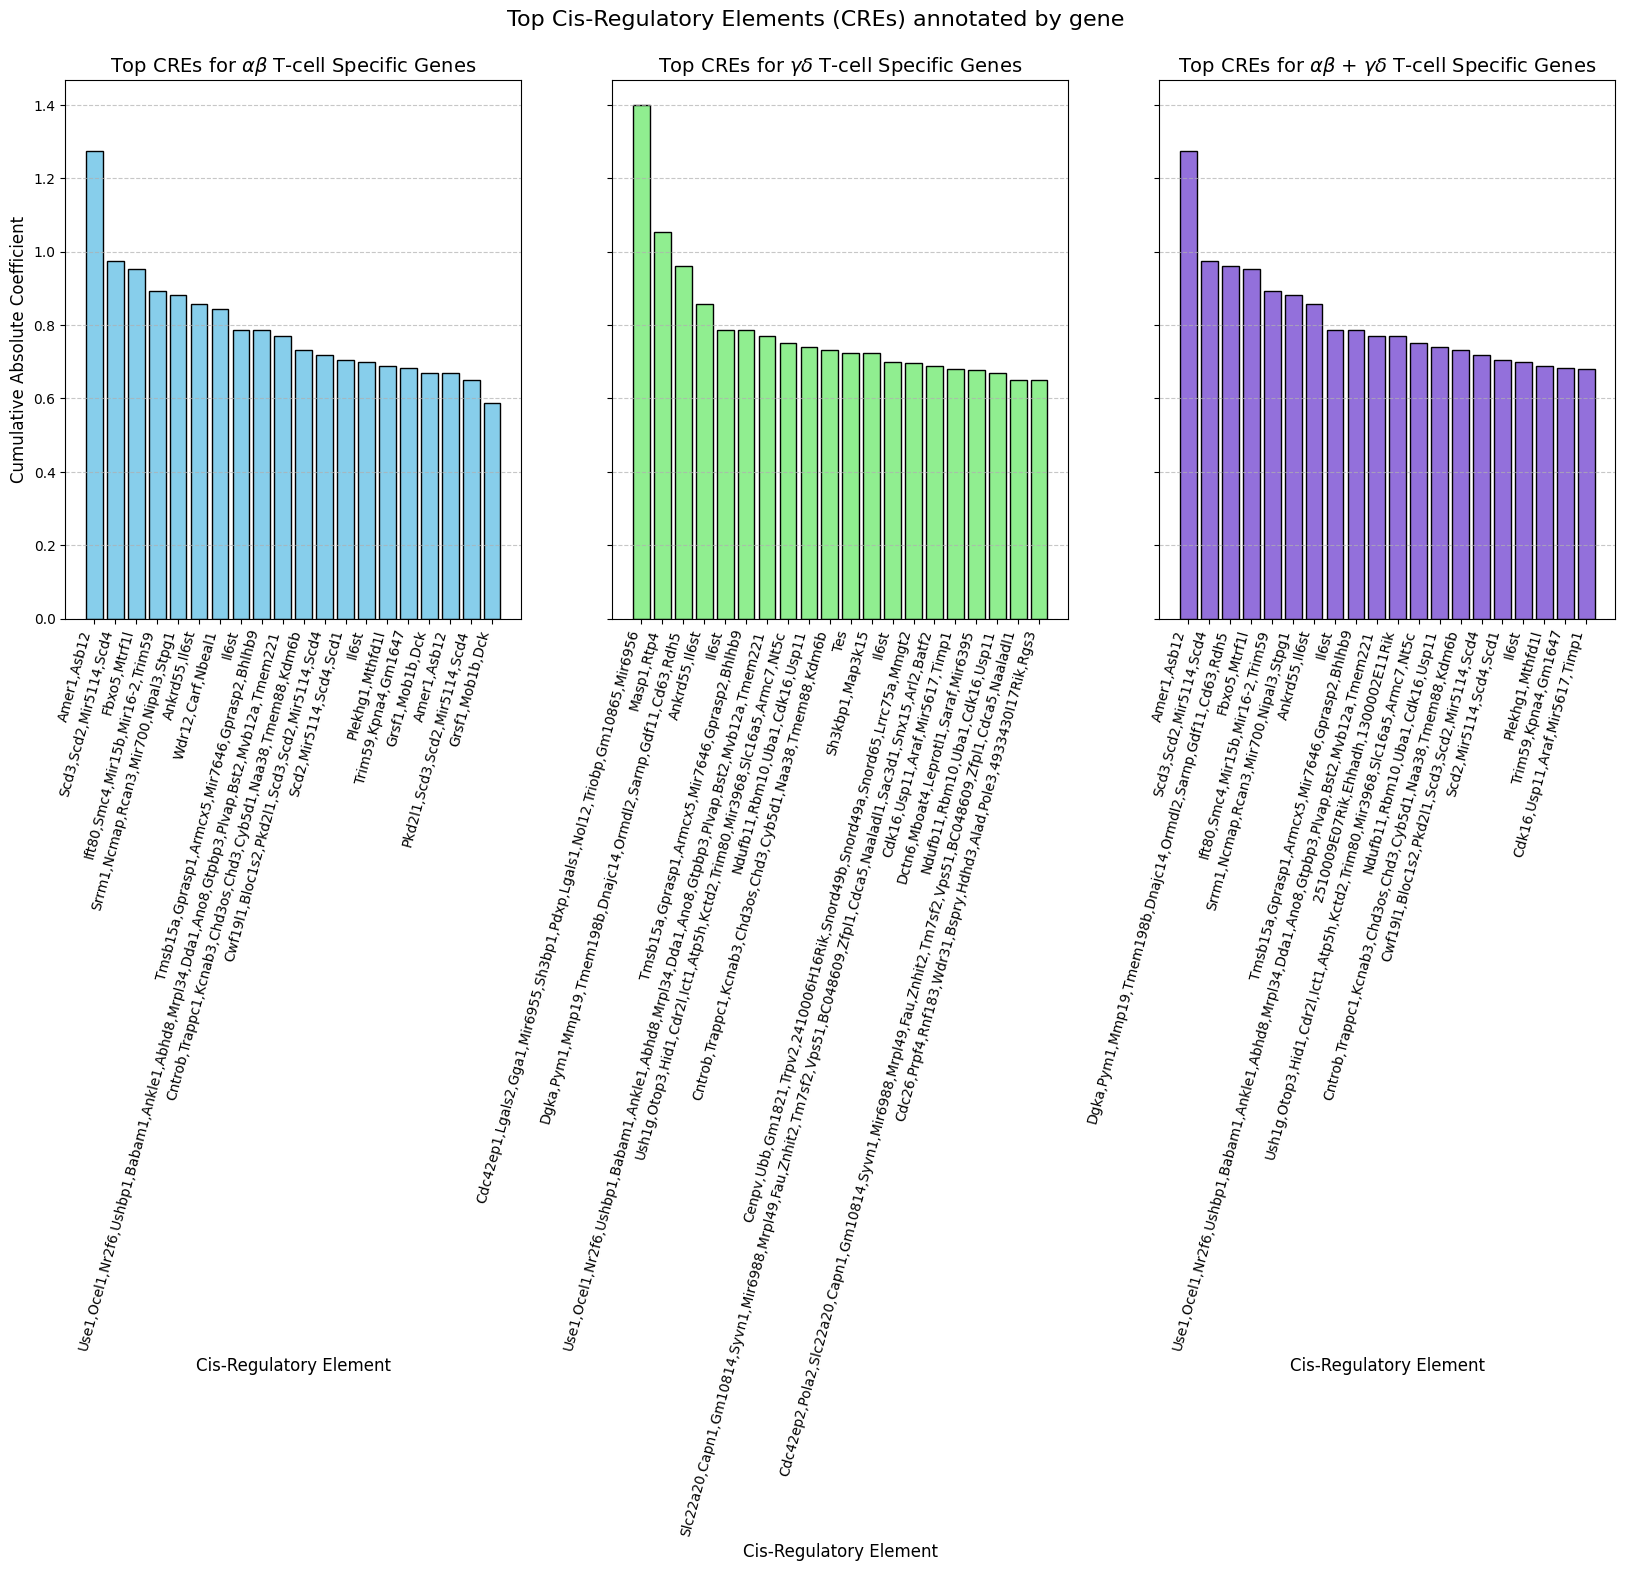

In [27]:
#CRes axtive in our lineage, bipartile plot, heatmap and barplot of top cres

logfc2_threshold = 0.2
top_cres_to_plot = 20
epsi = 1e-3

#helper functions

def calculate_log_fold_change(target_cell_types: list, full_rna_data: pd.DataFrame, epsilon: float) -> pd.Series:
    is_target_cell = full_rna_data.index.isin(target_cell_types)
    is_other_cell = ~is_target_cell

    target_samples_expr = full_rna_data[is_target_cell]
    other_samples_expr = full_rna_data[is_other_cell]

    if target_samples_expr.empty or other_samples_expr.empty:
        return pd.Series(dtype=float, index=full_rna_data.columns)

    mean_expr_target = target_samples_expr.mean(axis=0)
    mean_expr_other = other_samples_expr.mean(axis=0)
    
    common_genes = mean_expr_target.index.intersection(mean_expr_other.index)
    mean_expr_target = mean_expr_target[common_genes]
    mean_expr_other = mean_expr_other[common_genes]

    log_fc = np.log2((mean_expr_target + epsilon) / (mean_expr_other + epsilon))
    return log_fc.sort_index()

def calculate_cre_impact(specific_genes: list, coefs_data: dict) -> pd.Series:
    cre_impact = defaultdict(float)
    if not specific_genes:
        return pd.Series(dtype=float)

    for gene in specific_genes:
        if gene in coefs_data:
            coef_entry = coefs_data[gene]
            current_coefs = pd.Series(coef_entry) if isinstance(coef_entry, (pd.Series, dict)) else pd.Series([coef_entry])
            current_coefs_numeric = pd.to_numeric(current_coefs, errors='coerce').dropna()

            if not current_coefs_numeric.empty:
                for cre, val in current_coefs_numeric.items():
                    cre_impact[cre] += np.abs(val)
    
    impact_series = pd.Series(cre_impact)
    return pd.to_numeric(impact_series, errors='coerce').dropna().sort_values(ascending=False)


# big analysis

# Calculate Log2 Fold Changes based on cell types in RNA_T.index
log_fc_abgd = calculate_log_fold_change(ab_gd, RNA_T, epsi)
log_fc_ab = calculate_log_fold_change(ab, RNA_T, epsi)
log_fc_gd = calculate_log_fold_change(gd, RNA_T, epsi)

# Identify specific genes
abgd_specific_genes = log_fc_abgd[log_fc_abgd > logfc2_threshold].index.tolist() if not log_fc_abgd.empty else []
ab_specific_genes = log_fc_ab[log_fc_ab > logfc2_threshold].index.tolist() if not log_fc_ab.empty else []
gd_specific_genes = log_fc_gd[log_fc_gd > logfc2_threshold].index.tolist() if not log_fc_gd.empty else []

#only modeled genes
abgd_genes_modeled = [g for g in abgd_specific_genes if g in coefs]
ab_genes_modeled = [g for g in ab_specific_genes if g in coefs]
gd_genes_modeled = [g for g in gd_specific_genes if g in coefs]

# CRE-Impact Scores
cre_impact_series_abgd = calculate_cre_impact(abgd_genes_modeled, coefs)
cre_impact_series_ab = calculate_cre_impact(ab_genes_modeled, coefs)
cre_impact_series_gd = calculate_cre_impact(gd_genes_modeled, coefs)

results_abgd = results_df[results_df["Gene"].isin(abgd_specific_genes)]

# now for the plots

# Log2 Fold Change Distributions
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
plot_configs = [
    (log_fc_ab, r"$\alpha\beta$ T-cell Lineage", 'skyblue'),
    (log_fc_gd, r"$\gamma\delta$ T-cell Lineage", 'lightgreen'),
    (log_fc_abgd, r"$\alpha\beta$ + $\gamma\delta$ T-cell Lineage", 'mediumpurple')
]
for i, (log_fc, title, color) in enumerate(plot_configs):
    ax = axs[i]
    if not log_fc.empty:
        sns.histplot(log_fc, bins=30, kde=True, ax=ax, color=color, edgecolor='black')
        ax.axvline(logfc2_threshold, color='red', linestyle='--', label=f'Threshold ({logfc2_threshold})')
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"log$_2$ Fold Change", fontsize=12)
        if i == 0: ax.set_ylabel("Number of Genes", fontsize=12)
        ax.legend()
    else:
        ax.set_title(title, fontsize=14)
        ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_xlabel(r"log$_2$ Fold Change", fontsize=12)

plt.suptitle("Log$_2$ Fold Change Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# R-squared Scores
plt.figure(figsize=(12, 6))
if not results_abgd.empty:
    sns.barplot(data=results_abgd.head(top_cres_to_plot), x="Gene", y="R2", palette="viridis")
    plt.title("Variance Explained by ab_gd TT CREs (R² Score)", fontsize=16)
    plt.ylabel("R² Score", fontsize=12)
    plt.xlabel("Gene", fontsize=12)
    plt.xticks(rotation=75, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Top Gene Effect (Lasso Coefficients for a Single Gene)
if results_abgd is not None and not results_abgd.empty and results_abgd.shape[0] > 0 and results_abgd.iloc[0]["Gene"] in coefs:
    top_gene = results_abgd.iloc[0]["Gene"]
    top_coef_series = pd.to_numeric(pd.Series(coefs[top_gene]), errors='coerce').dropna()
    if not top_coef_series.empty:
        plt.figure(figsize=(15, 7))
        top_coef_series.plot(kind='bar', color=['red' if v < 0 else 'blue' for v in top_coef_series])
        plt.title(f"Lasso Coefficients for ab gd TC Genes: {top_gene}", fontsize=16)
        plt.ylabel("Effect on Expression", fontsize=12)
        plt.xlabel("CRE", fontsize=12)
        plt.xticks(rotation=75, ha='right', fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# Histogram of Explained Variance (R²)
plt.figure(figsize=(9, 5))
if not results_abgd.empty:
    sns.histplot(results_abgd['R2'], bins=15, kde=True, color='teal', edgecolor='black')
    plt.title("Distribution of Variance Explained (R²) for ab gd genes", fontsize=16)
    plt.xlabel("R² Score", fontsize=12)
    plt.ylabel("Number of Genes", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Top CREs Regulating Lineage-Specific Genes
fig, axs = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
cre_plot_configs = [
    (cre_impact_series_ab, r"$\alpha\beta$ T-cell Specific Genes", 'skyblue'),
    (cre_impact_series_gd, r"$\gamma\delta$ T-cell Specific Genes", 'lightgreen'),
    (cre_impact_series_abgd, r"$\alpha\beta$ + $\gamma\delta$ T-cell Specific Genes", 'mediumpurple')
]

# Mapping from CRE to nearby gene names
peak_to_gene = ATAC["genes.within.100Kb"].to_dict()

for i, (plot_data, title, color) in enumerate(cre_plot_configs):
    ax = axs[i]
    plot_series = plot_data.head(top_cres_to_plot)

    cre_ids = plot_series.index.tolist()
    gene_labels = [peak_to_gene.get(cre, cre) for cre in cre_ids]

    ax.bar(range(len(plot_series)), plot_series.values, color=color, edgecolor='black')
    ax.set_xticks(range(len(plot_series)))
    ax.set_xticklabels(gene_labels, rotation=75, fontsize=10)       
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

    ax.set_title(f"Top CREs for {title}", fontsize=14)
    ax.set_xlabel("Closest Gene (within 100Kb)", fontsize=12)
    if i == 0:
        ax.set_ylabel("Cumulative Absolute Coefficient", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xlabel("Cis-Regulatory Element", fontsize=12)

plt.suptitle("Top Cis-Regulatory Elements (CREs) annotated by gene", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




# barplot of R^2 variance for only ab gd T cells


C:\Users\helen\AppData\Local\Temp\ipykernel_19428\3475592827.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.head(top_cres_to_plot), x="Gene", y="R2", palette="viridis", ax=axs[0])
C:\Users\helen\AppData\Local\Temp\ipykernel_19428\3475592827.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=abgd_results_df.sort_values("R2", ascending=False).head(top_cres_to_plot),


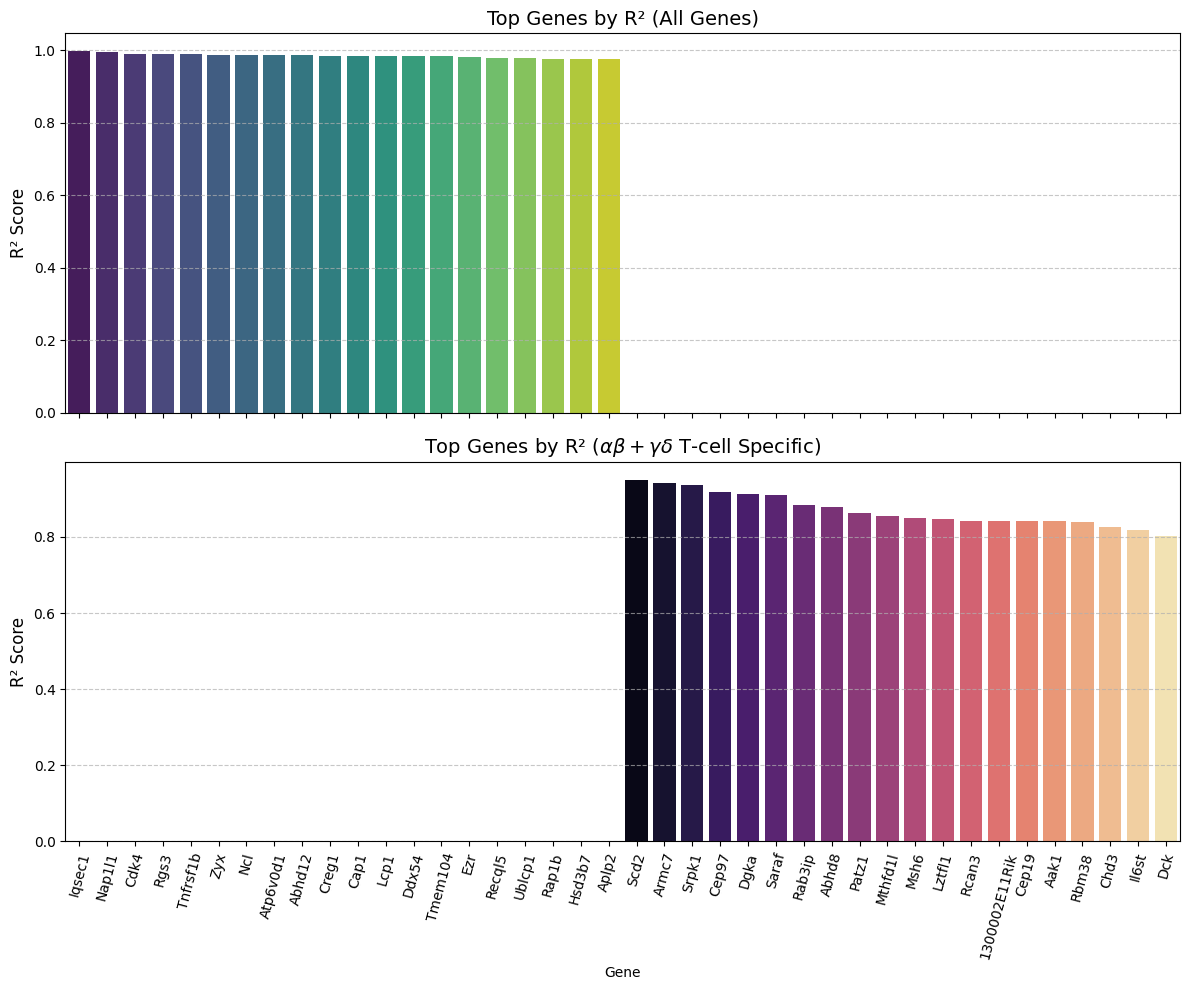

In [28]:
# Filter results_df for ab+gd lineage-specific genes
abgd_results_df = results_df[results_df["Gene"].isin(abgd_genes_modeled)]

# Barplot: Top CRE R² (all genes) + Top CRE R² (ab+gd-specific genes)
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: All modeled genes (original)
sns.barplot(data=results_df.head(top_cres_to_plot), x="Gene", y="R2", palette="viridis", ax=axs[0])
axs[0].set_title("Top Genes by R² (All Genes)", fontsize=14)
axs[0].set_ylabel("R² Score", fontsize=12)
axs[0].tick_params(axis='x', rotation=75, labelsize=10)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Only ab+gd lineage-specific modeled genes
if not abgd_results_df.empty:
    sns.barplot(data=abgd_results_df.sort_values("R2", ascending=False).head(top_cres_to_plot),
                x="Gene", y="R2", palette="magma", ax=axs[1])
    axs[1].set_title("Top Genes by R² ($\\alpha\\beta+\\gamma\\delta$ T-cell Specific)", fontsize=14)
    axs[1].set_ylabel("R² Score", fontsize=12)
    axs[1].tick_params(axis='x', rotation=75, labelsize=10)
    axs[1].grid(axis='y', linestyle='--', alpha=0.7)
else:
    axs[1].text(0.5, 0.5, "No lineage-specific modeled genes found",
                ha='center', va='center', fontsize=12)
    axs[1].set_axis_off()

plt.tight_layout()
plt.show()

In [29]:
# another try for ssubsets

# Get the sets of gene identifiers
genes_in_expression = set(RNA_T.columns)
genes_in_coefs = set(coefs.keys())

# Intersection and differences
common_genes = genes_in_expression & genes_in_coefs
only_in_expression = genes_in_expression - genes_in_coefs
only_in_coefs = genes_in_coefs - genes_in_expression

# Print summary
print(f"🧬 Total genes in RNA_T: {len(genes_in_expression)}")
print(f"🧠 Total genes in coefs: {len(genes_in_coefs)}")
print(f"✅ Genes in both: {len(common_genes)}")
print(f"⚠️ Genes only in RNA_T: {len(only_in_expression)}")
print(f"⚠️ Genes only in coefs: {len(only_in_coefs)}")

# Optionally inspect a few mismatches
print("\n🔍 Example genes only in RNA_T:", list(only_in_expression)[:5])
print("🔍 Example genes only in coefs:", list(only_in_coefs)[:5])

print("Genes above threshold for ab+gd lineage:", len(abgd_specific_genes))
print("Genes above threshold AND modeled:", len(abgd_genes_modeled))
print (results_df)

🧬 Total genes in RNA_T: 6451
🧠 Total genes in coefs: 6201
✅ Genes in both: 6201
⚠️ Genes only in RNA_T: 250
⚠️ Genes only in coefs: 0

🔍 Example genes only in RNA_T: ['Fam49b', 'Fam208b', 'Selk', 'Mettl20', 'Tmem173']
🔍 Example genes only in coefs: []
Genes above threshold for ab+gd lineage: 59
Genes above threshold AND modeled: 57
               Gene        R2  Num_CRs
2395         Iqsec1  0.997097      288
3130         Nap1l1  0.995010      297
884            Cdk4  0.991323      214
4241           Rgs3  0.990770      435
5372       Tnfrsf1b  0.990556      132
...             ...       ...      ...
6170          Zmym2  0.000000      111
6171          Zmym3  0.000000      115
816          Ccdc93  0.000000       92
815          Ccdc91  0.000000       68
15    1700037H04Rik  0.000000      420

[6201 rows x 3 columns]


# Analysis of lineage specific CREs

first we will reassure all our data is there and variables correctly assigned 

In [ ]:
# checking i have all important data
# CRE accesibillity matrix
ATAC_scores_T.set_index(ATAC_scores_T.columns[0], inplace=True)
X_raw = ATAC_scores_T  # shape: (n_samples x n_CREs)
X = StandardScaler().fit_transform(X_raw)

#gene expression matrix
y_raw = RNA_T # shape: (n_samples x n_genes)
y_all = StandardScaler().fit_transform(y_raw)

#cre genomic coordinates
import pyranges as pr

peak_half_width = 150
ATAC["Start"] = ATAC["Summit"] - peak_half_width
ATAC["End"] = ATAC["Summit"] + peak_half_width

#here we want non-negative start positions
ATAC["Start"] = ATAC["Start"].clip(lower=0)

# now were going to build a BED-like DataFrame and make a pyranges object outf it
cre_coords_df = ATAC.reset_index()[["chrom", "Start", "End", "ImmGenATAC1219.peakID"]]
cre_coords_df.columns = ["Chromosome", "Start", "End", "CRE_ID"]
cre_coords = pr.PyRanges(cre_coords_df)

#tss coordinates
gene_coords_df = Exons[["Chromosom", "Transcription Start", "Transcription End", "Genname"]].copy()
gene_coords_df.rename(columns={
    "Chromosom": "Chromosome","Transcription Start": "TSS", "Transcription End": "TSS_end", "Genname": "Gene"
}, inplace=True)
gene_coords = pr.PyRanges(gene_coords_df)

#cre to tss disance matrix
cre_mid = (cre_coords.Start + cre_coords.End) // 2
gene_mid = (gene_coords.TSS + gene_coords.TSS_end) // 2

# Output: distance_matrix[i, j] = distance between CRE i and Gene j
import numpy as np
distance_matrix = np.abs(cre_mid.values[:, None] - gene_mid.values[None, :])  # shape: (n_CREs, n_genes)

# lasso rgr coeff

all_peaks = set()
for coef_series in coefs.values():
    all_peaks.update(coef_series.index)

all_peaks = sorted(all_peaks)
coefficients = pd.DataFrame(index=coefs.keys(), columns=all_peaks).fillna(0)

for gene, coef_series in coefs.items():
    coefficients.loc[gene, coef_series.index] = coef_series.values

#gen/cre name identification
gene_names = y_raw.columns.tolist()
cre_names = X_raw.columns.tolist()

#lineage specific gene names
gene_lineage_labels = [g in ab_specific_genes for g in gene_names]


# 1. Check shapes match
assert X_raw.shape[0] == y_raw.shape[0], "⚠️ Sample count mismatch between ATAC and RNA!"
assert coefficients.shape == (y_all.shape[1], X.shape[1]), "⚠️ Coefficients shape mismatch!"

# 2. Check index/sample alignment
assert all(X_raw.index == y_raw.index), "⚠️ Sample labels in ATAC and RNA do not align!"

# 3. Check names
assert len(gene_names) == y_all.shape[1], "⚠️ Mismatch in number of gene names"
assert len(cre_names) == X.shape[1], "⚠️ Mismatch in number of CRE names"

# 4. Check CRE and gene coordinate counts match distance matrix
assert distance_matrix.shape == (len(cre_coords), len(gene_coords)), "⚠️ CRE–Gene distance matrix shape mismatch!"

# 5. Check lineage labels
assert len(gene_lineage_labels) == len(gene_names), "⚠️ gene_lineage_labels length mismatch"
print("✅ All checks passed.")

Cre_lineagemodeling_results = {
    "X": X,
    "y": y_all,
    "coefficients": coefficients,
    "gene_names": gene_names,
    "cre_names": cre_names,
    "distance_matrix": distance_matrix,
    "cre_coords": cre_coords,
    "gene_coords": gene_coords,
    "lineage_labels": gene_lineage_labels
}



In [ ]:
#comparing regression to correlation (associating res to ge)
#Regression accounts for co-accessibility and redundancy among CREs, while correlation may inflate indirect relationships.
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Example: compute correlation for one gene
gene_idx = 0
gene_expr = y_all[:, gene_idx]

corrs = [stats.pearsonr(X[:, i], gene_expr)[0] for i in range(X.shape[1])]
reg_coefs = coefficients[gene_idx, :]

# Scatter: Regression Coef vs. Correlation
plt.figure(figsize=(6, 5))
sns.scatterplot(x=corrs, y=reg_coefs)
plt.xlabel("Pearson Correlation")
plt.ylabel("Regression Coefficient")
plt.title(f"CRE-Gene Associations for {gene_names[gene_idx]}")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.show()


In [ ]:
# identify activating and repressing cres, classify them based off regression coeff
# For all genes and CREs
all_coefs = coefficients.flatten()
plt.figure(figsize=(6, 4))
sns.histplot(all_coefs, bins=50, kde=True)
plt.xlabel("Regression Coefficient")
plt.title("Distribution of CRE Effect Sizes")
plt.axvline(0, color='red', linestyle='--')
plt.show()

#Bimodal or skewed distributions can suggest activator/repressor dynamics. Negative coefficients may indicate repressive CREs.


In [ ]:
#classify CREs based on regulatory mode, count of how many genes are predominantly regulated by act/rep
gene_classes = []

for coef_row in coefficients:
    n_pos = np.sum(coef_row > 0)
    n_neg = np.sum(coef_row < 0)
    if n_pos > n_neg:
        gene_classes.append("Activator-dominant")
    elif n_neg > n_pos:
        gene_classes.append("Repressor-dominant")
    else:
        gene_classes.append("Mixed")

# Plot pie chart
gene_class_counts = pd.Series(gene_classes).value_counts()
gene_class_counts.plot.pie(autopct='%1.1f%%', figsize=(5, 5))
plt.ylabel("")
plt.title("Gene Regulatory Class")
plt.show()

#promoter specific repression?
# If promoter CREs are defined by distance to TSS
is_promoter = (distance_matrix < 2000)  # adjust as needed

# Check how many promoter CREs have negative coefficients
promoter_coefs = coefficients[:, is_promoter]
n_promoter_repressors = (promoter_coefs < 0).sum()


In [ ]:
# distance of repressors vs activator reg elements
coef_signs = np.sign(coefficients.flatten())
distances = distance_matrix.flatten()

df = pd.DataFrame({
    "Coefficient Sign": coef_signs,
    "Distance": np.log10(distances + 1)
})
df["Type"] = df["Coefficient Sign"].map({-1: "Repressor", 1: "Activator", 0: "Neutral"})

sns.violinplot(data=df[df["Type"] != "Neutral"], x="Type", y="Distance")
plt.title("CRE Distance from TSS by Effect Type")
plt.ylabel("log10 Distance (bp)")
plt.show()
# Repressors may act from distal sites, consistent with 3D chromatin looping models.

In [ ]:
# cres with dual functions that activate some genes while repressing others
sign_matrix = np.sign(coefficients)
dual_CREs = []

for i in range(sign_matrix.shape[1]):  # for each CRE
    signs = sign_matrix[:, i]
    if np.any(signs > 0) and np.any(signs < 0):
        dual_CREs.append(i)

print(f"Found {len(dual_CREs)} dual-function CREs.")

# Plot: CRE vs. gene with signed effect
import plotly.express as px

# Create long-form DataFrame
rows = []
for gene_idx in range(coefficients.shape[0]):
    for cre_idx in dual_CREs:
        coef = coefficients[gene_idx, cre_idx]
        if coef != 0:
            rows.append({
                "Gene": gene_names[gene_idx],
                "CRE": cre_names[cre_idx],
                "Effect": coef
            })

df_dual = pd.DataFrame(rows)
fig = px.scatter(df_dual, x="CRE", y="Gene", color="Effect", color_continuous_scale="RdBu")
fig.update_layout(title="Dual-function CREs")
fig.show()

#Such context-dependent CREs may interact with lineage-specific TFs or chromatin states.


In [ ]:
#cluster cres by effect direction (compare clustering by raw accessibility vs. regulatory influence) 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# 1. Cluster by accessibility
X_cre_scaled = StandardScaler().fit_transform(X.T)
pca_acc = PCA(n_components=10).fit_transform(X_cre_scaled)

# 2. Cluster by regression coefficients
coefs_cre_scaled = StandardScaler().fit_transform(coefficients.T)
pca_coef = PCA(n_components=10).fit_transform(coefs_cre_scaled)

# Plot t-SNE
tsne_acc = TSNE(n_components=2).fit_transform(pca_acc)
tsne_coef = TSNE(n_components=2).fit_transform(pca_coef)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(tsne_acc[:, 0], tsne_acc[:, 1], alpha=0.7)
ax[0].set_title("CREs Clustered by Accessibility")
ax[1].scatter(tsne_coef[:, 0], tsne_coef[:, 1], alpha=0.7, color='orange')
ax[1].set_title("CREs Clustered by Regulatory Influence")
plt.show()

#Functional CRE clustering based on gene-level influence may reveal co-regulated elements or modules not apparent from accessibility alone.